<a href="https://colab.research.google.com/github/infeimkr/codeit_ai4/blob/main/06_3%ED%8C%80_%EC%9E%84%EC%9D%B8%EC%B2%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 불러오기

In [1]:
!pip install torchinfo

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import cv2
import random
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset, ConcatDataset, WeightedRandomSampler
from torchvision.transforms import v2
import torchvision.models as models
from torch.optim.lr_scheduler import LambdaLR
from PIL import Image, ImageEnhance, ImageFilter
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import math
from tqdm import tqdm  # 진행 상황을 표시하기 위한 라이브러리
from collections import Counter
from torchinfo import summary
import time
import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, precision_recall_curve
import seaborn as sns
from IPython.display import display
import pandas as pd
from torch.amp import autocast, GradScaler

# 0. 미션 설명
## 미션 소개
이번 미션에서는 흉부 X-Ray 사진을 바탕으로 폐렴 환자를 구분하는 작업을 수행합니다. 이번 미션의 목표는 X-Ray 사진을 입력으로 받아 폐렴 여부를 구분하는 분류(Classification) 모델을 만드는 것입니다. 아래 데이터셋을 활용하여 다양한 이미지 전처리 및 증강 기법과 Transfer Learning과 Fine-Tuning 기법을 실험해보고, 모델의 성능을 평가해 보세요.

## 데이터 소개
- 데이터 링크(Chest X-Ray Images (Pneumonia))
- train: 훈련 데이터
- test: 테스트 데이터
- val: 검증 데이터

# 1. 데이터 불러오기 및 검토

In [2]:
if 'COLAB_RELEASE_TAG' in os.environ:
    check_google_colab = True
    print("온라인 Colab 환경(Google 서버)")
else:
    check_google_colab = False
    print("로컬 런타임 환경")

로컬 런타임 환경


In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    check_google_colab = True
    sub_path = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션6DATA"
    print("Google Colab 환경입니다.")
except ModuleNotFoundError:
    check_google_colab = False
    sub_path = "C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션6DATA"
    print("Local 환경입니다.")

Local 환경입니다.


In [4]:
# 폴더 경로 설정
if check_google_colab:
    train_dir = sub_path+"/train"
    val_dir = sub_path+"/val"
    test_dir = sub_path+"/test"
else:
    train_dir = sub_path+"/train"
    val_dir = sub_path+"/val"
    test_dir = sub_path+"/test"

print(train_dir)

C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션6DATA/train


In [5]:
# num_workers 설정을 위해 클래스 모듈화 불러오기
if sub_path not in sys.path:
    sys.path.append(sub_path)
    print(f"경로 추가: {sub_path}")

try:
    from xray_sampler_TransformDataset import TransformDataset
    print(f"모듈 임포트 성공")
except ImportError as e:
    print(f"모듈 임포트 중 오류가 발생했습니다: {e}")
    print(f"경로를 확인해주세요: {sub_path}")

경로 추가: C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션6DATA
모듈 임포트 성공


 - 각 폴더별로 이미지 갯수와 최대 최소 사이즈, 채널 수를 확인합니다.

### 전처리 확인용 셀. 결과 확인 후 주석 처리

In [6]:
# #### 결과 확인 후 주석처리
# def summarize_image_sizes(root_folder):
#     summary = {}

#     for label_folder in os.listdir(root_folder):
#         folder_path = os.path.join(root_folder, label_folder)
#         if not os.path.isdir(folder_path):
#             continue

#         img_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".jpeg")]
#         if not img_files:
#             continue

#         heights, widths, ratios, channels = [], [], [], []
#         for f in img_files:
#             img_path = os.path.join(folder_path, f)
#             img_data = np.fromfile(img_path, dtype=np.uint8)
#             img = cv2.imdecode(img_data, cv2.IMREAD_COLOR)
#             if img is None:
#                 continue

#             h, w = img.shape[:2]
#             heights.append(h)
#             widths.append(w)
#             ratios.append(w / h)
#             if len(img.shape) == 2:   # 흑백
#                 channels.append(1)
#             else:                     # 컬러 또는 알파 포함
#                 channels.append(img.shape[2])

#         if not heights or not widths:
#             continue

#         summary[label_folder] = {
#             "num_images": len(heights),
#             "height_min": int(np.min(heights)),
#             "height_max": int(np.max(heights)),
#             "ratio_mean": round(float(np.mean(ratios)),2),
#             "ratio_std": round(float(np.std(ratios)),2),
#             "width_min": int(np.min(widths)),
#             "width_max": int(np.max(widths)),
#             "channels_set": list(set(channels)),
#         }

#     return summary

# train_stats = summarize_image_sizes(train_dir)
# val_stats   = summarize_image_sizes(val_dir)
# test_stats  = summarize_image_sizes(test_dir)

In [7]:
#### 결과 확인 후 주석처리
# print("Train_img_summary---------")
# for folder in sorted(train_stats.keys()):
#     info = train_stats[folder]
#     print(f"{folder}: {info}")

# print("\nval_img_summary--------")
# for folder in sorted(val_stats.keys()):
#     info = val_stats[folder]
#     print(f"{folder}: {info}")

# print("\ntest_img_summary---------")
# for folder in sorted(test_stats.keys()):
#     info = test_stats[folder]
#     print(f"{folder}: {info}")

### 정보 서머리 코드 결과값
Train_img_summary---------
NORMAL: {'num_images': 1341, 'height_min': 672, 'height_max': 2663, 'ratio_mean': 1.23, 'ratio_std': 0.13, 'width_min': 912, 'width_max': 2916, 'channels_set': [3]}
PNEUMONIA: {'num_images': 3875, 'height_min': 127, 'height_max': 2304, 'ratio_mean': 1.51, 'ratio_std': 0.25, 'width_min': 384, 'width_max': 2772, 'channels_set': [3]}

val_img_summary--------
NORMAL: {'num_images': 8, 'height_min': 928, 'height_max': 1416, 'ratio_mean': 1.24, 'ratio_std': 0.08, 'width_min': 1240, 'width_max': 1776, 'channels_set': [3]}
PNEUMONIA: {'num_images': 8, 'height_min': 592, 'height_max': 1128, 'ratio_mean': 1.51, 'ratio_std': 0.13, 'width_min': 968, 'width_max': 1664, 'channels_set': [3]}

test_img_summary---------
NORMAL: {'num_images': 234, 'height_min': 496, 'height_max': 2713, 'ratio_mean': 1.37, 'ratio_std': 0.21, 'width_min': 984, 'width_max': 2752, 'channels_set': [3]}
PNEUMONIA: {'num_images': 390, 'height_min': 344, 'height_max': 1456, 'ratio_mean': 1.53, 'ratio_std': 0.22, 'width_min': 728, 'width_max': 2000, 'channels_set': [3]}

### 전처리 계획
1. val가 16장 밖에 안되서, train 에서 일부 가져와서 적용 (8:2)
2. 학습 데이터 불균형 Train_N:Train_P = 1341:3875 -> WeightedRandomSampler 적용
3. 들쭉날쭉한 사이즈에 맞춰 256으로 스케일링 후, train은 랜덤 크롭 224, val/test는 센터 크롭 224 적용


#### 전처리 수치 선언

In [8]:
RAW_RESIZE = 256
CROP_SIZE = 224
EXTRA_VAL_RATE = 0.2
RANDOM_ROTATION = 5

# 2. 데이터 전처리

In [9]:
# 첫 로드 리사이즈
base_transform = transforms.Resize((RAW_RESIZE))

# raw 데이터셋 - ImageFolder 사용
train_dataset_raw = datasets.ImageFolder(train_dir, transform=base_transform)
val_dataset_raw   = datasets.ImageFolder(val_dir, transform=base_transform)
test_dataset_raw  = datasets.ImageFolder(test_dir, transform=base_transform)

# 데이터셋 카운트
train_targets = [label for _, label in train_dataset_raw.samples]
train_counts = Counter(train_targets)

val_targets = [label for _, label in val_dataset_raw.samples]
val_counts = Counter(val_targets)

test_targets = [label for _, label in test_dataset_raw.samples]
test_counts = Counter(test_targets)

print("train raw:", {k: train_counts[k] for k in sorted(train_counts.keys())})
print("val raw:", {k: val_counts[k] for k in sorted(val_counts.keys())})
print("test raw:", {k: test_counts[k] for k in sorted(test_counts.keys())})

train raw: {0: 1341, 1: 3875}
val raw: {0: 8, 1: 8}
test raw: {0: 234, 1: 390}


- train raw 데이터에서 test raw 데이터의 비율로 var로 옮기기

In [10]:
# test raw 비율로 train 데이터셋에서 extra var 가져오기
train_targets_arr = np.array([label for _, label in train_dataset_raw.samples])

normal_idx = np.where(train_targets_arr == 0)[0]
pneumonia_idx = np.where(train_targets_arr == 1)[0]

test_normal = test_counts[0]
test_pneumonia = test_counts[1]

ratio_normal = test_normal / (test_normal + test_pneumonia)
ratio_pneumonia = test_pneumonia / (test_normal + test_pneumonia)

# extra val 크기 (normal 기준으로 뽑기)
extra_val_normal_count = int(len(normal_idx) * EXTRA_VAL_RATE)
extra_val_pneumonia_count = int(extra_val_normal_count * (ratio_pneumonia / ratio_normal))

extra_val_normal_idx = np.random.choice(normal_idx, extra_val_normal_count, replace=False)
extra_val_pneumonia_idx = np.random.choice(pneumonia_idx, extra_val_pneumonia_count, replace=False)

extra_val_idx = np.concatenate([extra_val_normal_idx, extra_val_pneumonia_idx])
np.random.shuffle(extra_val_idx)

# train_idx = extra val 외 나머지 인덱스
train_idx = np.array([i for i in range(len(train_targets_arr)) if i not in extra_val_idx])

train_dataset = Subset(train_dataset_raw, train_idx)
extra_val_dataset = Subset(train_dataset_raw, extra_val_idx)

# val 데이터셋
val_dataset = ConcatDataset([val_dataset_raw, extra_val_dataset])

# 데이터셋 카운트
train_subset_labels = [train_dataset_raw.targets[i] for i in train_dataset.indices]
train_counts = Counter(train_subset_labels)

val_subset_labels = []
val_subset_labels += val_dataset_raw.targets
val_subset_labels += [train_dataset_raw.targets[i] for i in extra_val_dataset.indices]
val_counts = Counter(val_subset_labels)

print("train:", {k: train_counts[k] for k in sorted(train_counts.keys())})
print("val:",   {k: val_counts[k] for k in sorted(val_counts.keys())})
print("test:",  {k: test_counts[k] for k in sorted(test_counts.keys())})

train: {0: 1073, 1: 3429}
val: {0: 276, 1: 454}
test: {0: 234, 1: 390}


In [11]:
# 환경에 따라 배치 사이즈 변경
if check_google_colab:
    batch_size = 128
else:
    batch_size = 64

In [12]:
# 트랜스폼
train_transform = v2.Compose([
    v2.RandomResizedCrop(CROP_SIZE,
                         scale=(0.9, 1.0),
                         antialias=True),
#    v2.RandomHorizontalFlip(), # 의료용이라 삭제 처리
#    v2.RandomRotation(RANDOM_ROTATION), # 5
    v2.RandomAffine(degrees=RANDOM_ROTATION, translate=(0.05, 0.05)),
#    v2.ColorJitter(brightness=0.1, contrast=0.1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225]),
])

val_test_transform = v2.Compose([
    v2.CenterCrop(CROP_SIZE),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225]),
])

# num_workers 오류 해결을 위해 xray_sampler_TransformDataset.py로 옮김
# class TransformDataset(torch.utils.data.Dataset):
#     def __init__(self, subset, transform=None):
#         self.subset = subset
#         self.transform = transform
#     def __getitem__(self, idx):
#         img, label = self.subset[idx]
#         if self.transform:
#             img = self.transform(img)
#         return img, label
#     def __len__(self):
#         return len(self.subset)

train_dataset_final = TransformDataset(train_dataset, transform=train_transform)
val_dataset_final = TransformDataset(val_dataset, transform=val_test_transform)
test_dataset_final = TransformDataset(test_dataset_raw, transform=val_test_transform)

targets = [label for _, label in train_dataset_final]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader
train_loader = DataLoader(train_dataset_final, batch_size, sampler=sampler, num_workers=6, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset_final, batch_size, shuffle=False, num_workers=6, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset_final, batch_size, shuffle=False, num_workers=6, pin_memory=True, persistent_workers=True)

print("Train:", len(train_dataset_final))
print("Val:", len(val_dataset_final))
print("Test:", len(test_dataset_final))

Train: 4502
Val: 730
Test: 624


In [13]:
# 테스트 1 에폭, train_loader 라벨 밸런스 확인용
def count_sampled_labels(dataloader):
    counts = Counter()
    for _, labels in tqdm(dataloader, leave=True, desc='Sampled'):
        counts.update(labels.tolist())
    return counts

sampled_train_counts = count_sampled_labels(train_loader)

print("\nSampled train labels:", sampled_train_counts)

Sampled: 100%|█████████████████████████████████████████████████████████████████████████| 71/71 [00:50<00:00,  1.40it/s]


Sampled train labels: Counter({0: 2326, 1: 2176})


- train_dataset_final 내에 label 별로 대략 1:1 비율 확인

# 3. 모델링


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 1) model_simpleCNN
- SimpleCNN
    -> 이진 분류 from Scratch (확인용)

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_p=0.5):  # dropout 확률 기본 0.5
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * (CROP_SIZE // 4) * (CROP_SIZE // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout
        self.dropout_conv = nn.Dropout(p=dropout_p/2)
        self.dropout_fc = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout_conv(x)                       # conv2 앞 dropout

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout_conv(x)                       # conv 블록마다 dropout

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)                         # fully connected 앞 dropout
        x = self.fc2(x)
        return x

### 2) Transfer Learning (resNet18)
    -> resNet18 기반

#### 2-1) model_resNet18_FE
- resNet 18 + IMAGENET1K_V1 - Feature Extractor -> Frozen

In [16]:
def get_resnet_feature_extraction(num_classes=2):
    model = models.resnet18(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False   # freeze 모든 conv layer

    model.fc = nn.Linear(model.fc.in_features, num_classes)  # classifier 교체
    return model

#### 2-2) model_resNet18_P
- resNet 18 + IMAGENET1K_V1 - Partial -> unfreeze layer4, fs 앞에 약한 드랍아웃추가

In [17]:
def get_resnet_partial(num_classes=2, unfreeze_from_layer=4):
    model = models.resnet18(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False   # freeze 모든 conv layer

    for param in model.layer4.parameters(): # unfreeze layer 4
        param.requires_grad = True

    model.fc = nn.Sequential(
        nn.Dropout(p=0.25),
        nn.Linear(model.fc.in_features, 2)
    )  # classifier 교체
    return model

#### 2-3) model_resNet18_FT
- resNet 18 + IMAGENET1K_V1 - Fine-tuning

In [18]:
def get_resnet_finetune(num_classes=2):
    model = models.resnet18(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = True   # unfreeze 모든 conv layer

    model.fc = nn.Linear(model.fc.in_features, num_classes)  # classifier 교체
    return model

### 3) 모델 선언 및 학습 진행

In [19]:
# 학습 시각화
def plot_loss_acc(train_losses, train_accs, val_losses, val_accs, model_title=None):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8,4))
    plt.suptitle(model_title)
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, len(epochs) + 1, max(1, len(epochs) // 15)), rotation=45, fontsize=6)
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, len(epochs) + 1, max(1, len(epochs) // 15)), rotation=45, fontsize=6)
    plt.legend()
    plt.title("Accuracy Curve")

    plt.tight_layout()
    plt.show()

 - 의료 자료 판단이라 False Negative 가 늘어나는 위험성이 있는 부분은 인지하고 있으나, 몇 번의 튜닝에도 Normal을 Pneumonia로 판단하는 False Positive가 높아서, 검증겸 테스트 목적으로 손실 가중치를 Normal에 더 크게 부여하여 재학습 시도 -> loss가 너무 튀어서 제거 처리

In [43]:
# 학습 & 검증 루프
# [Normal, Pneumonia] 가중치: Normal을 더 무겁게
# class_weights = torch.tensor([2.0, 1.0], device=device)
# criterion_train = torch.nn.CrossEntropyLoss(weight=class_weights) //테스트 후 제거
criterion_train = torch.nn.CrossEntropyLoss(label_smoothing=0.05)
criterion_val = torch.nn.CrossEntropyLoss()

num_classes = 2 # 이진분류
# def get_lrs(optimizer):
#     return [pg["lr"] for pg in optimizer.param_groups]

def train_model(
    model, train_loader, val_loader, optimizer,
    epochs=10, model_title=None, scheduler=None, grad_clip=None,
    min_epochs=5, patience=10, min_delta=2e-3,
):
    scaler = GradScaler("cuda")
    best_val = float("inf")
    best_state = None
    best_epoch = 0
    wait = 0

    global_step = 0

    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    print_learning_time = 0
    total_learning_time = 0

    model = model.to(device)

    for epoch in range(epochs):
        start_time = time.time()  # epoch 시작 시간

        # Train ===============
        model.train()
        if model_title in ('resNet18 (Frozen)', 'resNet18 (Partial)'): # batchNorm2d 통계값 강제 블록킹
            set_frozen_blocks_eval(model, model_title)

        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, leave=False, desc='Train'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            with autocast("cuda"):
                outputs = model(inputs)
                loss = criterion_train(outputs, labels)

            scaler.scale(loss).backward()

            if grad_clip is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)
            scaler.update()

            if scheduler is not None and (epoch > 0 or total > 0):  # 첫 배치만 skip
                scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total * 100
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation ===========
        model.eval()
        running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            with autocast("cuda"):
                for inputs, labels in tqdm(val_loader, leave=False, desc='Val'):
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)

                    loss = criterion_val(outputs, labels)
                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)

        epoch_val_loss = running_loss / max(val_total, 1)
        val_acc = 100.0 * val_correct / max(val_total, 1)
        val_losses.append(epoch_val_loss)
        val_accs.append(val_acc)

        elapsed = time.time() - start_time
        print_learning_time += elapsed
        total_learning_time += elapsed

        # Log ====================
        curr_lrs = ["{:.2e}".format(pg["lr"]) for pg in optimizer.param_groups]
        print(f"\rEpoch {epoch+1}/{epochs} | "
            f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% | "
            f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
            f"LRs: {curr_lrs} | ",
            f"Processing Time: {print_learning_time:.1f}s | ",
              end="\n")
        print_learning_time = 0

        # Early Stop ==============
        improved = (best_val - epoch_val_loss) > min_delta
        if improved:
            best_val = epoch_val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            best_epoch = epoch + 1
            wait = 0
        else:
            wait += 1
            # 최소 에폭을 채운 뒤에만 early stop 판단
            if (epoch + 1) >= min_epochs and wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # 성능 모델 복원
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    elapsed_str = str(datetime.timedelta(seconds=int(total_learning_time))) + f" (epoch {epoch+1})"
    print(f"Total Learning Time: {elapsed_str} | Best epoch: {best_epoch}")
    plot_loss_acc(train_losses, train_accs, val_losses, val_accs, model_title)

    return {
        "model_title": model_title,
        "elapsed": elapsed_str,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs
    }

In [41]:
# 환경에 따라 최대 에폭 사이즈 변경
if check_google_colab:
    EPOCHS = 60
else:
    EPOCHS = 30

MIN_EPOCHS = 8
WARMUP_EPOCHS = 3

- 전체 에폭 80 -> 30 (15~30 내외 얼리스탑 확인)
- 각 모델에 따라 하이퍼 파라미터 튜닝

#### 3-1) SimpleCNN 학습

- val loss가 많이 튀는 경향이 있어 LR = 1e-3 -> 4e-4 로 진행
- 웜업 -> 코사인 시퀀스 스케줄러로 진행하던 부분을 plateau 도입
- 다시 OneCycleLR 전환
- dropout 확률 0.5 -> 0.3 -> 0.4
- LR = 1e-3 -> 2e-4 -> 5e-4 -> 4e-4

===== SimpleCNN =====


Epoch 1/30 | Train Loss: 0.5823 | Train Acc: 79.79% | Val Loss: 0.5523 | Val Acc: 71.78% | LRs: ['1.99e-04'] |  Processing Time: 41.8s | 


Epoch 2/30 | Train Loss: 0.3099 | Train Acc: 90.58% | Val Loss: 0.4857 | Val Acc: 74.93% | LRs: ['3.33e-04'] |  Processing Time: 40.6s | 


Epoch 3/30 | Train Loss: 0.2826 | Train Acc: 91.83% | Val Loss: 0.4668 | Val Acc: 75.62% | LRs: ['4.00e-04'] |  Processing Time: 41.7s | 


Epoch 4/30 | Train Loss: 0.2566 | Train Acc: 93.85% | Val Loss: 0.3165 | Val Acc: 87.40% | LRs: ['3.99e-04'] |  Processing Time: 40.7s | 


Epoch 5/30 | Train Loss: 0.2424 | Train Acc: 94.38% | Val Loss: 0.3413 | Val Acc: 84.52% | LRs: ['3.95e-04'] |  Processing Time: 40.7s | 


Epoch 6/30 | Train Loss: 0.2418 | Train Acc: 94.58% | Val Loss: 0.2911 | Val Acc: 89.18% | LRs: ['3.88e-04'] |  Processing Time: 40.0s | 


Epoch 7/30 | Train Loss: 0.2325 | Train Acc: 95.22% | Val Loss: 0.3073 | Val Acc: 87.40% | LRs: ['3.79e-04'] |  Processing Time: 40.9s | 


Epoch 8/30 | Train Loss: 0.2307 | Train Acc: 94.98% | Val Loss: 0.2932 | Val Acc: 90.41% | LRs: ['3.67e-04'] |  Processing Time: 40.7s | 


Epoch 9/30 | Train Loss: 0.2207 | Train Acc: 95.49% | Val Loss: 0.3210 | Val Acc: 87.26% | LRs: ['3.53e-04'] |  Processing Time: 40.7s | 


Epoch 10/30 | Train Loss: 0.2100 | Train Acc: 96.20% | Val Loss: 0.3028 | Val Acc: 86.71% | LRs: ['3.37e-04'] |  Processing Time: 40.9s | 


Epoch 11/30 | Train Loss: 0.2217 | Train Acc: 95.34% | Val Loss: 0.2800 | Val Acc: 89.04% | LRs: ['3.19e-04'] |  Processing Time: 40.6s | 


Epoch 12/30 | Train Loss: 0.2037 | Train Acc: 96.38% | Val Loss: 0.2559 | Val Acc: 91.23% | LRs: ['3.00e-04'] |  Processing Time: 40.5s | 


Epoch 13/30 | Train Loss: 0.1978 | Train Acc: 96.56% | Val Loss: 0.2589 | Val Acc: 91.78% | LRs: ['2.79e-04'] |  Processing Time: 40.2s | 


Epoch 14/30 | Train Loss: 0.2154 | Train Acc: 95.74% | Val Loss: 0.2523 | Val Acc: 91.51% | LRs: ['2.57e-04'] |  Processing Time: 40.8s | 


Epoch 15/30 | Train Loss: 0.1988 | Train Acc: 96.51% | Val Loss: 0.2967 | Val Acc: 88.63% | LRs: ['2.35e-04'] |  Processing Time: 40.9s | 


Epoch 16/30 | Train Loss: 0.2006 | Train Acc: 96.47% | Val Loss: 0.2852 | Val Acc: 88.77% | LRs: ['2.12e-04'] |  Processing Time: 40.0s | 


Epoch 17/30 | Train Loss: 0.2005 | Train Acc: 96.60% | Val Loss: 0.2671 | Val Acc: 90.14% | LRs: ['1.89e-04'] |  Processing Time: 39.7s | 


Epoch 18/30 | Train Loss: 0.1928 | Train Acc: 96.76% | Val Loss: 0.2735 | Val Acc: 91.10% | LRs: ['1.65e-04'] |  Processing Time: 39.0s | 


Epoch 19/30 | Train Loss: 0.1964 | Train Acc: 96.62% | Val Loss: 0.2826 | Val Acc: 88.22% | LRs: ['1.43e-04'] |  Processing Time: 40.6s | 


Epoch 20/30 | Train Loss: 0.1856 | Train Acc: 97.29% | Val Loss: 0.3005 | Val Acc: 87.12% | LRs: ['1.21e-04'] |  Processing Time: 42.3s | 


Epoch 21/30 | Train Loss: 0.1897 | Train Acc: 97.02% | Val Loss: 0.2991 | Val Acc: 87.67% | LRs: ['1.00e-04'] |  Processing Time: 40.2s | 


Epoch 22/30 | Train Loss: 0.1870 | Train Acc: 97.16% | Val Loss: 0.2577 | Val Acc: 90.14% | LRs: ['8.08e-05'] |  Processing Time: 40.4s | 
Early stopping at epoch 22
Total Learning Time: 0:14:53 (epoch 22) | Best epoch: 14


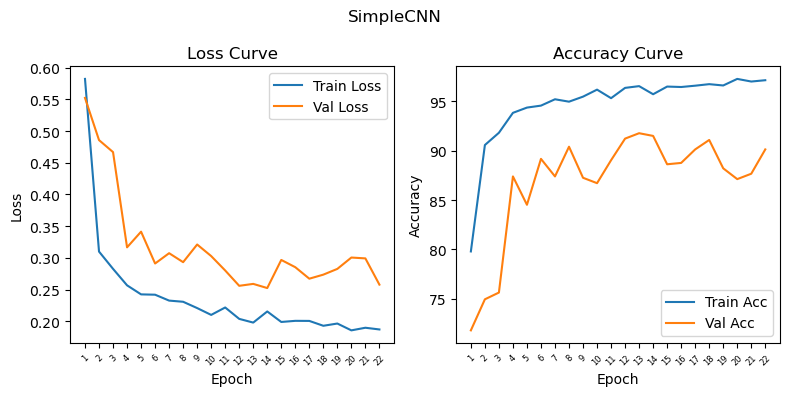

In [44]:
# SimpleCNN 학습
model_simpleCNN = SimpleCNN(num_classes, dropout_p=0.4).to(device)

optimizer = torch.optim.AdamW(
    model_simpleCNN.parameters(), # 전체
    lr=4e-4, weight_decay=6e-4
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=4e-4, steps_per_epoch=len(train_loader), epochs=EPOCHS,
    pct_start=WARMUP_EPOCHS/float(EPOCHS), anneal_strategy="cos", div_factor=3.0, final_div_factor=4e2
)
# warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=WARMUP_EPOCHS+2)
# plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-6
# )

model_title = "SimpleCNN"
print("="*5, model_title, "="*5)

simpleCNN_info = train_model(
    model_simpleCNN, train_loader, val_loader,
    optimizer, epochs=EPOCHS, model_title=model_title,
    scheduler=scheduler, grad_clip=1.0,
    min_epochs=MIN_EPOCHS, patience=8, min_delta=2e-3)

#### 3-2) resNet18_Frozen 학습

- LR 2e-5 -> 7e-5 -> 5e-5 -> 1e-3 -> 5e-4 -> 3e-4
- plateau 스캐줄러 적용 -> OneCycleLR 으로 전환
- LR 요동으로 Layer 1~4 의 BatchNorm2D 레이어의 통계량도 동결 적용

===== resNet18 (Frozen) =====


Epoch 1/30 | Train Loss: 0.6179 | Train Acc: 69.52% | Val Loss: 0.5693 | Val Acc: 67.12% | LRs: ['1.49e-04'] |  Processing Time: 40.5s | 


Epoch 2/30 | Train Loss: 0.4080 | Train Acc: 90.23% | Val Loss: 0.3697 | Val Acc: 84.79% | LRs: ['2.50e-04'] |  Processing Time: 39.9s | 


Epoch 3/30 | Train Loss: 0.3105 | Train Acc: 92.27% | Val Loss: 0.2426 | Val Acc: 91.64% | LRs: ['3.00e-04'] |  Processing Time: 39.6s | 


Epoch 4/30 | Train Loss: 0.2654 | Train Acc: 93.69% | Val Loss: 0.1996 | Val Acc: 92.60% | LRs: ['2.99e-04'] |  Processing Time: 39.6s | 


Epoch 5/30 | Train Loss: 0.2669 | Train Acc: 93.18% | Val Loss: 0.1808 | Val Acc: 93.56% | LRs: ['2.96e-04'] |  Processing Time: 40.7s | 


Epoch 6/30 | Train Loss: 0.2412 | Train Acc: 94.40% | Val Loss: 0.1846 | Val Acc: 93.01% | LRs: ['2.91e-04'] |  Processing Time: 40.3s | 


Epoch 7/30 | Train Loss: 0.2367 | Train Acc: 94.76% | Val Loss: 0.1682 | Val Acc: 93.97% | LRs: ['2.84e-04'] |  Processing Time: 40.2s | 


Epoch 8/30 | Train Loss: 0.2357 | Train Acc: 94.62% | Val Loss: 0.1506 | Val Acc: 94.66% | LRs: ['2.75e-04'] |  Processing Time: 40.3s | 


Epoch 9/30 | Train Loss: 0.2306 | Train Acc: 95.09% | Val Loss: 0.1473 | Val Acc: 95.07% | LRs: ['2.65e-04'] |  Processing Time: 40.9s | 


Epoch 10/30 | Train Loss: 0.2378 | Train Acc: 94.69% | Val Loss: 0.1342 | Val Acc: 96.30% | LRs: ['2.53e-04'] |  Processing Time: 39.4s | 


Epoch 11/30 | Train Loss: 0.2275 | Train Acc: 95.34% | Val Loss: 0.1352 | Val Acc: 95.62% | LRs: ['2.40e-04'] |  Processing Time: 41.4s | 


Epoch 12/30 | Train Loss: 0.2272 | Train Acc: 95.16% | Val Loss: 0.1356 | Val Acc: 95.48% | LRs: ['2.25e-04'] |  Processing Time: 40.5s | 


Epoch 13/30 | Train Loss: 0.2257 | Train Acc: 95.11% | Val Loss: 0.1342 | Val Acc: 95.62% | LRs: ['2.09e-04'] |  Processing Time: 40.3s | 


Epoch 14/30 | Train Loss: 0.2208 | Train Acc: 95.65% | Val Loss: 0.1367 | Val Acc: 95.48% | LRs: ['1.93e-04'] |  Processing Time: 40.7s | 


Epoch 15/30 | Train Loss: 0.2209 | Train Acc: 95.40% | Val Loss: 0.1342 | Val Acc: 95.75% | LRs: ['1.76e-04'] |  Processing Time: 40.0s | 
Early stopping at epoch 15
Total Learning Time: 0:10:04 (epoch 15) | Best epoch: 10


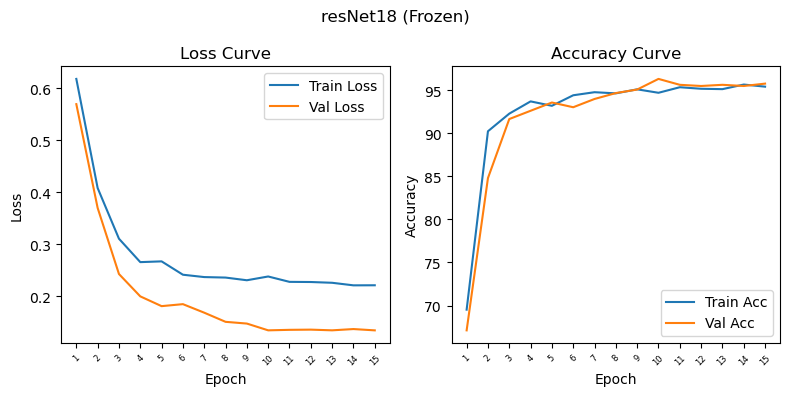

In [45]:
def set_frozen_blocks_eval(m, model_title=None): # BatchNorm2D 레이어의 통계량도 동결
    # layer1~3은 P 동결
    m.layer1.eval()
    m.layer2.eval()
    m.layer3.eval()
    if model_title == "resNet18 (Frozen)": # 4는 FE 동결
        m.layer4.eval()

# resNet18_Frozen
model_resNet18_FE = get_resnet_feature_extraction(num_classes).to(device)

optimizer = torch.optim.AdamW(
    model_resNet18_FE.fc.parameters(), # fc만
    lr=3e-4, weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, total_steps=EPOCHS*len(train_loader),
    pct_start=WARMUP_EPOCHS/float(EPOCHS), anneal_strategy="cos", div_factor=3.0, final_div_factor=4e2
)
# warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=WARMUP_EPOCHS)
# plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.1, patience=2, min_lr=1e-6
# )

model_title = "resNet18 (Frozen)"
print("="*5, model_title, "="*5)

resNet18_FE_info = train_model(
    model_resNet18_FE, train_loader, val_loader,
    optimizer, epochs=EPOCHS, model_title=model_title,
    scheduler=scheduler, grad_clip=1.0,
    min_epochs=MIN_EPOCHS, patience=5, min_delta=2e-3,
)

#### 3-3) resNet18_Partial 학습

- l4_params, LR = 3e-6 -> 3e-4 -> 1e-4 -> 5e-5 -> 5e-6 -> 4e-6
- fc_params, LR = 7e-5 -> 5e-4 -> 8e-4 -> 5e-4 -> 5e-4 -> 3e-5
- plateau 스캐줄러 적용 ->OneCycleLR 으로 전환

===== resNet18 (Partial) =====


Epoch 1/30 | Train Loss: 0.6292 | Train Acc: 64.70% | Val Loss: 0.5408 | Val Acc: 75.89% | LRs: ['1.99e-06', '1.49e-05'] |  Processing Time: 41.4s | 


Epoch 2/30 | Train Loss: 0.4192 | Train Acc: 86.10% | Val Loss: 0.2927 | Val Acc: 92.47% | LRs: ['3.33e-06', '2.50e-05'] |  Processing Time: 41.4s | 


Epoch 3/30 | Train Loss: 0.2906 | Train Acc: 92.09% | Val Loss: 0.1865 | Val Acc: 95.48% | LRs: ['4.00e-06', '3.00e-05'] |  Processing Time: 40.2s | 


Epoch 4/30 | Train Loss: 0.2402 | Train Acc: 94.62% | Val Loss: 0.1523 | Val Acc: 95.34% | LRs: ['3.99e-06', '2.99e-05'] |  Processing Time: 40.4s | 


Epoch 5/30 | Train Loss: 0.2253 | Train Acc: 95.14% | Val Loss: 0.1524 | Val Acc: 94.38% | LRs: ['3.95e-06', '2.96e-05'] |  Processing Time: 40.9s | 


Epoch 6/30 | Train Loss: 0.2112 | Train Acc: 95.94% | Val Loss: 0.1452 | Val Acc: 94.25% | LRs: ['3.88e-06', '2.91e-05'] |  Processing Time: 41.4s | 


Epoch 7/30 | Train Loss: 0.2002 | Train Acc: 96.42% | Val Loss: 0.1518 | Val Acc: 93.97% | LRs: ['3.79e-06', '2.84e-05'] |  Processing Time: 40.3s | 


Epoch 8/30 | Train Loss: 0.2042 | Train Acc: 96.31% | Val Loss: 0.1466 | Val Acc: 94.11% | LRs: ['3.67e-06', '2.75e-05'] |  Processing Time: 40.7s | 


Epoch 9/30 | Train Loss: 0.2011 | Train Acc: 96.42% | Val Loss: 0.1678 | Val Acc: 93.70% | LRs: ['3.53e-06', '2.65e-05'] |  Processing Time: 40.7s | 


Epoch 10/30 | Train Loss: 0.1932 | Train Acc: 96.80% | Val Loss: 0.1447 | Val Acc: 94.38% | LRs: ['3.37e-06', '2.53e-05'] |  Processing Time: 41.2s | 


Epoch 11/30 | Train Loss: 0.1916 | Train Acc: 97.09% | Val Loss: 0.1446 | Val Acc: 94.66% | LRs: ['3.19e-06', '2.40e-05'] |  Processing Time: 41.1s | 


Epoch 12/30 | Train Loss: 0.1899 | Train Acc: 97.18% | Val Loss: 0.1490 | Val Acc: 94.38% | LRs: ['3.00e-06', '2.25e-05'] |  Processing Time: 41.7s | 


Epoch 13/30 | Train Loss: 0.1872 | Train Acc: 97.18% | Val Loss: 0.1663 | Val Acc: 93.42% | LRs: ['2.79e-06', '2.09e-05'] |  Processing Time: 41.2s | 


Epoch 14/30 | Train Loss: 0.1908 | Train Acc: 97.05% | Val Loss: 0.1915 | Val Acc: 92.60% | LRs: ['2.57e-06', '1.93e-05'] |  Processing Time: 40.5s | 
Early stopping at epoch 14
Total Learning Time: 0:09:33 (epoch 14) | Best epoch: 6


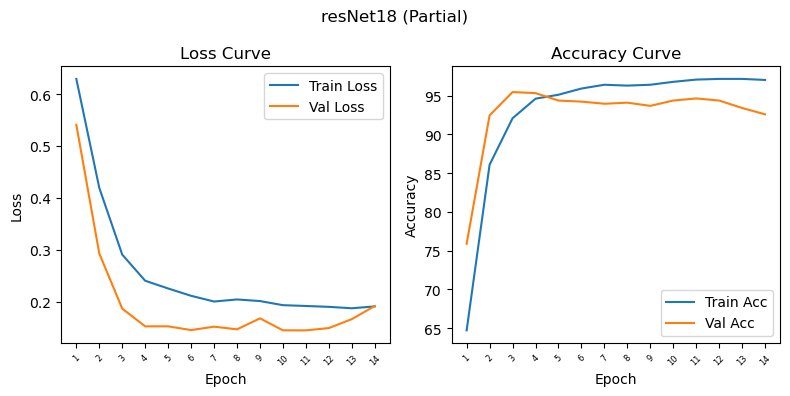

In [53]:
# resNet18_Partial
model_resNet18_P = get_resnet_partial(num_classes, unfreeze_from_layer=4).to(device) # fc 직전 마지막 conv layer

l4_params = [p for p in model_resNet18_P.layer4.parameters() if p.requires_grad]    # layer4 conv
fc_params = [p for p in model_resNet18_P.fc.parameters() if p.requires_grad]        # fc

optimizer = torch.optim.AdamW(
    [
      {"params": l4_params, "lr": 4e-6},
      {"params": fc_params, "lr": 3e-5},
    ],
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=[4e-6, 3e-5], total_steps=EPOCHS*len(train_loader),
    pct_start=WARMUP_EPOCHS/float(EPOCHS), anneal_strategy="cos", div_factor=3.0, final_div_factor=4e2
)
# warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=WARMUP_EPOCHS)
# plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.65, patience=3, min_lr=1e-6
# )

model_title = "resNet18 (Partial)"
print("="*5, model_title, "="*5)

resNet18_P_info = train_model(
    model_resNet18_P, train_loader, val_loader,
    optimizer, epochs=EPOCHS, model_title=model_title,
    scheduler=scheduler, grad_clip=1.0,
    min_epochs=MIN_EPOCHS, patience=8, min_delta=2e-3,
)

#### 3-4) resNet18_fine-tune 학습

- ly_params, LR = 1e-5 -> 1e-6
- fc_params, LR = 7e-5 -> 5e-4 -> 8e-4 -> 5e-4 -> 5e-4 -> 3e-5

===== resNet18 (Fine-tuning) =====


Epoch 1/30 | Train Loss: 0.6312 | Train Acc: 65.55% | Val Loss: 0.5888 | Val Acc: 72.47% | LRs: ['5.01e-07', '1.50e-05'] |  Processing Time: 40.6s | 


Epoch 2/30 | Train Loss: 0.5236 | Train Acc: 80.70% | Val Loss: 0.4728 | Val Acc: 83.15% | LRs: ['8.36e-07', '2.51e-05'] |  Processing Time: 41.2s | 


Epoch 3/30 | Train Loss: 0.4102 | Train Acc: 89.25% | Val Loss: 0.3445 | Val Acc: 90.14% | LRs: ['1.00e-06', '3.00e-05'] |  Processing Time: 40.9s | 


Epoch 4/30 | Train Loss: 0.3253 | Train Acc: 92.16% | Val Loss: 0.2734 | Val Acc: 91.23% | LRs: ['9.97e-07', '2.99e-05'] |  Processing Time: 40.4s | 


Epoch 5/30 | Train Loss: 0.2784 | Train Acc: 94.05% | Val Loss: 0.2275 | Val Acc: 92.60% | LRs: ['9.86e-07', '2.96e-05'] |  Processing Time: 40.6s | 


Epoch 6/30 | Train Loss: 0.2670 | Train Acc: 92.89% | Val Loss: 0.2047 | Val Acc: 93.42% | LRs: ['9.70e-07', '2.91e-05'] |  Processing Time: 40.3s | 


Epoch 7/30 | Train Loss: 0.2444 | Train Acc: 93.96% | Val Loss: 0.1959 | Val Acc: 93.15% | LRs: ['9.46e-07', '2.84e-05'] |  Processing Time: 40.8s | 


Epoch 8/30 | Train Loss: 0.2421 | Train Acc: 94.25% | Val Loss: 0.1899 | Val Acc: 93.56% | LRs: ['9.17e-07', '2.75e-05'] |  Processing Time: 39.7s | 


Epoch 9/30 | Train Loss: 0.2191 | Train Acc: 95.47% | Val Loss: 0.1931 | Val Acc: 92.88% | LRs: ['8.83e-07', '2.65e-05'] |  Processing Time: 40.9s | 


Epoch 10/30 | Train Loss: 0.2250 | Train Acc: 95.29% | Val Loss: 0.1837 | Val Acc: 93.42% | LRs: ['8.43e-07', '2.53e-05'] |  Processing Time: 40.6s | 


Epoch 11/30 | Train Loss: 0.2114 | Train Acc: 96.11% | Val Loss: 0.1868 | Val Acc: 93.01% | LRs: ['7.98e-07', '2.39e-05'] |  Processing Time: 40.2s | 


Epoch 12/30 | Train Loss: 0.2105 | Train Acc: 95.98% | Val Loss: 0.1721 | Val Acc: 94.52% | LRs: ['7.49e-07', '2.25e-05'] |  Processing Time: 40.8s | 


Epoch 13/30 | Train Loss: 0.1997 | Train Acc: 96.33% | Val Loss: 0.1677 | Val Acc: 94.52% | LRs: ['6.98e-07', '2.09e-05'] |  Processing Time: 40.6s | 


Epoch 14/30 | Train Loss: 0.2050 | Train Acc: 96.20% | Val Loss: 0.1748 | Val Acc: 93.29% | LRs: ['6.43e-07', '1.93e-05'] |  Processing Time: 41.2s | 


Epoch 15/30 | Train Loss: 0.2023 | Train Acc: 96.56% | Val Loss: 0.1724 | Val Acc: 94.11% | LRs: ['5.86e-07', '1.76e-05'] |  Processing Time: 40.7s | 


Epoch 16/30 | Train Loss: 0.1967 | Train Acc: 96.69% | Val Loss: 0.1809 | Val Acc: 93.29% | LRs: ['5.29e-07', '1.59e-05'] |  Processing Time: 40.4s | 


Epoch 17/30 | Train Loss: 0.1994 | Train Acc: 96.53% | Val Loss: 0.1656 | Val Acc: 94.11% | LRs: ['4.71e-07', '1.41e-05'] |  Processing Time: 40.3s | 


Epoch 18/30 | Train Loss: 0.1995 | Train Acc: 96.18% | Val Loss: 0.1834 | Val Acc: 93.01% | LRs: ['4.13e-07', '1.24e-05'] |  Processing Time: 40.8s | 


Epoch 19/30 | Train Loss: 0.1991 | Train Acc: 96.40% | Val Loss: 0.1902 | Val Acc: 92.47% | LRs: ['3.56e-07', '1.07e-05'] |  Processing Time: 39.5s | 


Epoch 20/30 | Train Loss: 0.1904 | Train Acc: 96.93% | Val Loss: 0.1640 | Val Acc: 94.25% | LRs: ['3.02e-07', '9.05e-06'] |  Processing Time: 41.1s | 


Epoch 21/30 | Train Loss: 0.1971 | Train Acc: 96.76% | Val Loss: 0.1991 | Val Acc: 92.05% | LRs: ['2.50e-07', '7.50e-06'] |  Processing Time: 40.7s | 


Epoch 22/30 | Train Loss: 0.1978 | Train Acc: 96.67% | Val Loss: 0.1924 | Val Acc: 92.47% | LRs: ['2.01e-07', '6.04e-06'] |  Processing Time: 40.0s | 
Early stopping at epoch 22
Total Learning Time: 0:14:52 (epoch 22) | Best epoch: 17


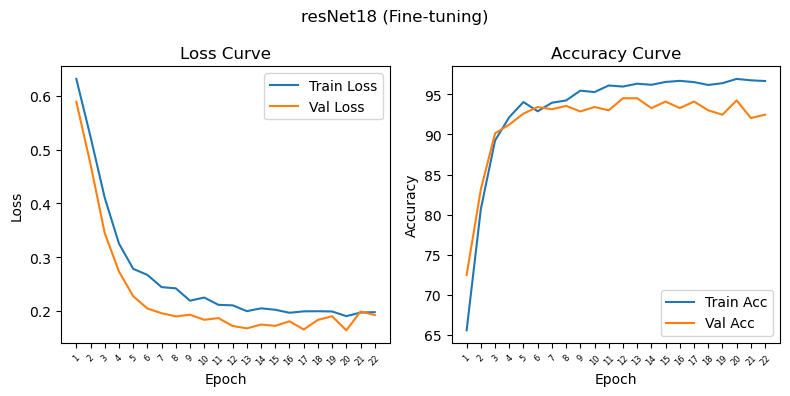

In [25]:
# resNet18_fine-tune
model_resNet18_FT = get_resnet_finetune(num_classes).to(device)

ly_params = [p for n,p in model_resNet18_FT.named_parameters() if "fc" not in n]    # fc 빼고 나머지
fc_params = [p for p in model_resNet18_FT.fc.parameters()]                          # fc

optimizer = torch.optim.AdamW(
    [
      {"params": ly_params, "lr": 1e-6}, # fc 제외 아주 낮게 설정
      {"params": fc_params, "lr": 3e-5},
    ],
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=[1e-6, 3e-5], total_steps=EPOCHS*len(train_loader),
    pct_start=WARMUP_EPOCHS/float(EPOCHS), anneal_strategy="cos", div_factor=3.0, final_div_factor=4e2
)
# warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=WARMUP_EPOCHS)
# plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.3, patience=2, min_lr=1e-6
# )

model_title = "resNet18 (Fine-tuning)"
print("="*5, model_title, "="*5)

resNet18_FT_info = train_model(
    model_resNet18_FT, train_loader, val_loader,
    optimizer, epochs=EPOCHS, model_title=model_title,
    scheduler=scheduler, grad_clip=1.0,
    min_epochs=MIN_EPOCHS-2, patience=5, min_delta=2e-3,
)

In [26]:
summary(model_resNet18_P, input_size=(batch_size, 3, CROP_SIZE, CROP_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 2]                   --
├─Conv2d: 1-1                            [64, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        (128)
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]  

# 4. 평가 지표 확인


- 정확도, 정밀도, 재현율, F1-Score 등 모델들의 전체적인 평가 지표 확인

In [54]:
@torch.inference_mode()  # = no_grad의 superset(추론 최적화)
def predict_proba(model, dataloader, device, temp_scaler=None, return_loss=False, criterion=None):
    """loader 전체에 대해 (y, p1[, loss_mean]) 반환. p1 = class-1 확률"""
    model.eval()
    y_all, p_all = [], []
    loss_sum, total = 0.0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        if temp_scaler is not None:
            logits = temp_scaler(logits)
        if return_loss and criterion is not None:
            loss_sum += criterion(logits, y).item() * x.size(0)
            total += y.size(0)

        p1 = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        y_all.append(y.cpu().numpy()); p_all.append(p1)

    y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
    if return_loss and criterion is not None:
        return y_all, p_all, loss_sum / max(total, 1)
    return y_all, p_all


def apply_threshold(p1, threshold=0.5):
    return (p1 >= threshold).astype(np.int64)


def summarize_metrics(y_true, y_pred, loss_mean=None, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="binary", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="binary", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="binary", zero_division=0)

    print("\n", "="*15, model_name, "="*15)
    print(f"📊 Classification Report for {model_name}")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"], zero_division=0))
    if loss_mean is not None:
        print(f"✅ Loss: {loss_mean:.4f}")
    print(f"✅ Accuracy: {acc:.2%}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall: {rec:.4f}")
    print(f"✅ F1-score: {f1:.4f}", "\n")
    return acc, prec, rec, f1

In [55]:
@torch.inference_mode()  # = no_grad의 superset(추론 최적화)
def evaluate_model(model, dataloader, criterion, device, model_name="Model",
                   threshold=0.5, temp_scaler=None, verbose=True):
    y_true, p1, loss_mean = predict_proba(
        model, dataloader, device, temp_scaler=temp_scaler,
        return_loss=(criterion is not None), criterion=criterion
    )
    y_pred = apply_threshold(p1, threshold)
    if verbose:
        return (*summarize_metrics(y_true, y_pred, loss_mean, model_name), y_true, y_pred)
    else:
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        return acc, prec, rec, f1, y_true, y_pred

## 4-1. 검증(val) 데이터셋으로 평가 지표 확인 (참고용)


 =============== SimpleCNN ===============
📊 Classification Report for SimpleCNN
              precision    recall  f1-score   support

      Normal       0.98      0.79      0.88       276
   Pneumonia       0.89      0.99      0.94       454

    accuracy                           0.92       730
   macro avg       0.93      0.89      0.91       730
weighted avg       0.92      0.92      0.91       730

✅ Loss: 0.2524
✅ Accuracy: 91.51%
✅ Precision: 0.8874
✅ Recall: 0.9890
✅ F1-score: 0.9354 


 =============== resNet18 (Frozen) ===============
📊 Classification Report for resNet18 (Frozen)
              precision    recall  f1-score   support

      Normal       0.94      0.96      0.95       276
   Pneumonia       0.98      0.96      0.97       454

    accuracy                           0.96       730
   macro avg       0.96      0.96      0.96       730
weighted avg       0.96      0.96      0.96       730

✅ Loss: 0.1342
✅ Accuracy: 96.30%
✅ Precision: 0.9776
✅ Recall: 0.9626
✅ F

,Model,Accuracy,Precision,Recall,F1-score,Learning Time
0,SimpleCNN,91.51%,0.8874,0.9890,0.9354,0:14:53 (epoch 22)
1,resNet18 (Frozen),96.30%,0.9776,0.9626,0.9700,0:10:04 (epoch 15)
2,resNet18 (Partial),94.79%,0.9298,0.9912,0.9595,0:09:25 (epoch 14)
3,resNet18 (Fine-tuning),94.11%,0.9237,0.9868,0.9542,0:14:52 (epoch 22)


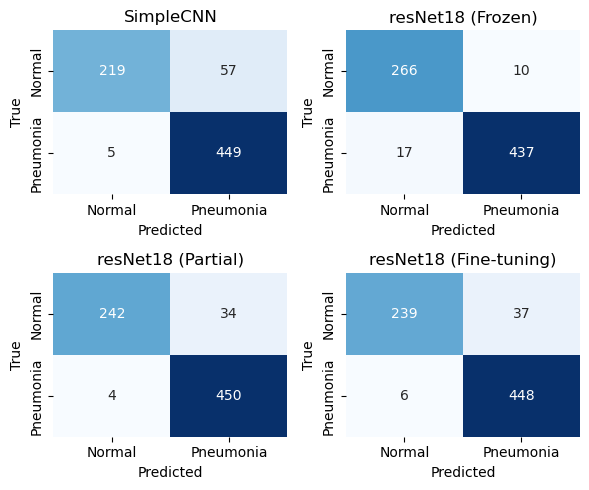

In [46]:
# val로 확인
models_to_val = {
    simpleCNN_info["model_title"]: model_simpleCNN,
    resNet18_FE_info["model_title"] : model_resNet18_FE,
    resNet18_P_info["model_title"] : model_resNet18_P,
    resNet18_FT_info["model_title"] : model_resNet18_FT
}

results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": []}
cm_data = {}

criterion = torch.nn.CrossEntropyLoss()

for model_name, model in models_to_val.items():
    acc, prec, rec, f1, y_true, y_pred = evaluate_model(
        model, val_loader, criterion, device, model_name, threshold=0.5
    )
    results["Model"].append(model_name)
    results["Accuracy"].append(acc)
    results["Precision"].append(prec)
    results["Recall"].append(rec)
    results["F1-score"].append(f1)
    cm_data[model_name] = (y_true, y_pred)

df_val_results = pd.DataFrame(results)

# 학습 소요 시간 추가
df_val_results["Learning Time"] =  [simpleCNN_info["elapsed"],
                                resNet18_FE_info["elapsed"],
                                resNet18_P_info["elapsed"],
                                resNet18_FT_info["elapsed"]
    ]

print("\n", "="*35, "Val Score", "="*35)
display(df_val_results.style.format({
    "Accuracy": "{:.2%}",
    "Precision": "{:.4f}",
    "Recall": "{:.4f}",
    "F1-score": "{:.4f}"
}))

# 혼동행렬
fig, axes = plt.subplots(2, 2, figsize=(6, 5))
axes = axes.ravel()

for ax, (model_name, _) in zip(axes, models_to_val.items()):
    y_true, y_pred = cm_data[model_name]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Pneumonia"],
                yticklabels=["Normal", "Pneumonia"],
                ax=ax, cbar=False)
    ax.set_title(model_name)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")

plt.tight_layout()
plt.show()

## 4-2. Threshold 찾기
- 전체적으로 f1스코어를 높이기 위한 방법을 고민
- 기본값 0.5가 아닌 각 모델의 f1 스코어의 임계값을 찾아서 적용
- 검증 데이터셋으로 `최적의 임계값` (Threshold) 을 찾아 테스트 셋에 적용하는 것으로 진행

In [56]:
@torch.inference_mode()
def find_best_threshold(model, val_loader, device, target='f1', prec_target=0.85, temp_scaler=None):
    model.eval()
    y, p = predict_proba(model, val_loader, device, temp_scaler=temp_scaler)

    if target == 'f1':
        ts = np.linspace(0.1, 0.9, 81)
        f1s = [f1_score(y, (p >= t).astype(int)) for t in ts]
        return float(ts[int(np.argmax(f1s))])
    else:
        # 정밀도(precision) >= prec_target에서 재현율 최대가 되는 임계값
        prec, rec, ts = precision_recall_curve(y, p)
        mask = prec[:-1] >= prec_target
        return float(ts[mask][np.argmax(rec[:-1][mask])]) if mask.any() else 0.5

In [57]:
# 각 모델별로 threshold
thresholds = {}
for name, model in models_to_val.items():
    t_star = find_best_threshold(model, val_loader, device, target='f1')
    thresholds[name] = t_star
    print(f"[{name}] best threshold on val = {t_star:.3f}")

[SimpleCNN] best threshold on val = 0.690
[resNet18 (Frozen)] best threshold on val = 0.490
[resNet18 (Partial)] best threshold on val = 0.610
[resNet18 (Fine-tuning)] best threshold on val = 0.640


## 4-3. 테스트(test) 데이터셋에 Threshold 적용 및 지표 확인
- threshold 값을 적용하지 않은 test셋과 적용한 test셋 결과 지표 비교


 =============== SimpleCNN ===============
📊 Classification Report for SimpleCNN
              precision    recall  f1-score   support

      Normal       0.94      0.19      0.31       234
   Pneumonia       0.67      0.99      0.80       390

    accuracy                           0.69       624
   macro avg       0.80      0.59      0.56       624
weighted avg       0.77      0.69      0.62       624

✅ Loss: 0.7492
✅ Accuracy: 69.07%
✅ Precision: 0.6707
✅ Recall: 0.9923
✅ F1-score: 0.8004 


 =============== resNet18 (Frozen) ===============
📊 Classification Report for resNet18 (Frozen)
              precision    recall  f1-score   support

      Normal       0.95      0.52      0.67       234
   Pneumonia       0.77      0.98      0.86       390

    accuracy                           0.81       624
   macro avg       0.86      0.75      0.77       624
weighted avg       0.84      0.81      0.79       624

✅ Loss: 0.4117
✅ Accuracy: 80.77%
✅ Precision: 0.7722
✅ Recall: 0.9821
✅ F

,Model,Accuracy,Precision,Recall,F1-score
0,SimpleCNN,69.07%,0.6707,0.9923,0.8004
1,resNet18 (Frozen),80.77%,0.7722,0.9821,0.8646
2,resNet18 (Partial),75.16%,0.7172,0.9949,0.8335
3,resNet18 (Fine-tuning),75.80%,0.7209,1.0000,0.8378


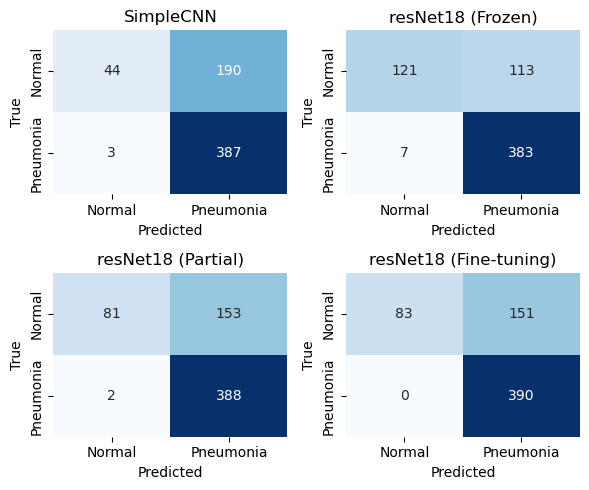

In [58]:
# test로 확인 (Threshold 적용X)
models_to_test = models_to_val

test_results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": []}
cm_test_base = {}

for model_name, model in models_to_test.items():
    acc, prec, rec, f1, y_true, y_pred = evaluate_model(
        model, test_loader, criterion, device, model_name, threshold=0.5
    )
    test_results["Model"].append(model_name)
    test_results["Accuracy"].append(acc)
    test_results["Precision"].append(prec)
    test_results["Recall"].append(rec)
    test_results["F1-score"].append(f1)
    cm_test_base[model_name] = (y_true, y_pred)

df_test_results = pd.DataFrame(test_results)

print("\n", "="*35, "Test Score", "="*35)
display(df_test_results.style.format({
    "Accuracy": "{:.2%}",
    "Precision": "{:.4f}",
    "Recall": "{:.4f}",
    "F1-score": "{:.4f}"
}))

# 혼동행렬
fig, axes = plt.subplots(2, 2, figsize=(6, 5))
axes = axes.ravel()

for ax, (model_name, _) in zip(axes, models_to_test.items()):
    y_true, y_pred = cm_test_base[model_name]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Pneumonia"],
                yticklabels=["Normal", "Pneumonia"],
                ax=ax, cbar=False)
    ax.set_title(model_name)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")

plt.tight_layout()
plt.show()


>>> Testing [SimpleCNN] with threshold = 0.690

 =============== SimpleCNN @ t=0.690 ===============
📊 Classification Report for SimpleCNN @ t=0.690
              precision    recall  f1-score   support

      Normal       0.93      0.29      0.45       234
   Pneumonia       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.82      0.64      0.63       624
weighted avg       0.79      0.73      0.68       624

✅ Loss: 0.7492
✅ Accuracy: 72.76%
✅ Precision: 0.7000
✅ Recall: 0.9872
✅ F1-score: 0.8191 


>>> Testing [resNet18 (Frozen)] with threshold = 0.490

 =============== resNet18 (Frozen) @ t=0.490 ===============
📊 Classification Report for resNet18 (Frozen) @ t=0.490
              precision    recall  f1-score   support

      Normal       0.94      0.51      0.66       234
   Pneumonia       0.77      0.98      0.86       390

    accuracy                           0.81       624
   macro avg       0.86      0.75      

,Model,Accuracy,Precision,Recall,F1-score
0,SimpleCNN,72.76%,0.7000,0.9872,0.8191
1,resNet18 (Frozen),80.61%,0.7706,0.9821,0.8636
2,resNet18 (Partial),77.72%,0.7400,0.9923,0.8478
3,resNet18 (Fine-tuning),80.29%,0.7613,0.9974,0.8635


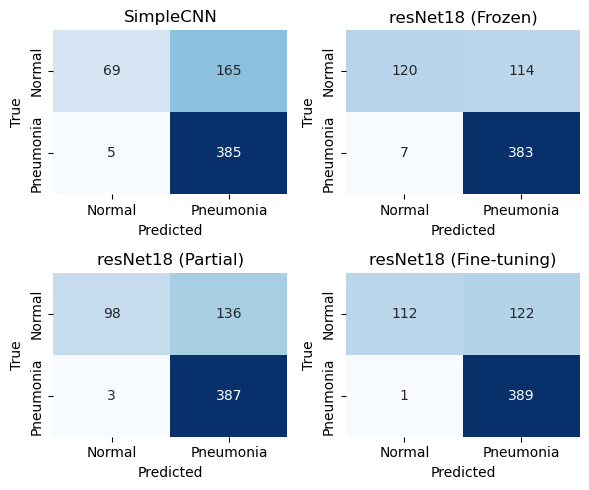

In [59]:
models_to_test_with_threshold = models_to_val  # 동일한 dict 재사용

test_with_threshold_results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": []}
cm_test_with_threshold = {}

for name, model in models_to_test_with_threshold.items():
    t = float(thresholds.get(name, 0.5))
    print(f"\n>>> Testing [{name}] with threshold = {t:.3f}")
    acc, prec, rec, f1, y_true, y_pred = evaluate_model(
        model=model,
        dataloader=test_loader,
        criterion=criterion,
        device=device,
        model_name=f"{name} @ t={t:.3f}",
        threshold=t,
    )
    test_with_threshold_results["Model"].append(name)
    test_with_threshold_results["Accuracy"].append(acc)
    test_with_threshold_results["Precision"].append(prec)
    test_with_threshold_results["Recall"].append(rec)
    test_with_threshold_results["F1-score"].append(f1)
    cm_test_with_threshold[name] = (y_true, y_pred)

df_test_with_threshold = pd.DataFrame(test_with_threshold_results)
print("\n", "="*25, "Test Score (tuned thresholds)", "="*25)
display(df_test_with_threshold.style.format({
    "Accuracy": "{:.2%}",
    "Precision": "{:.4f}",
    "Recall": "{:.4f}",
    "F1-score": "{:.4f}"
}))

fig, axes = plt.subplots(2, 2, figsize=(6, 5))  # 모델 4개 기준
axes = axes.ravel()
for ax, (name, _) in zip(axes, models_to_test_with_threshold.items()):
    y_true, y_pred = cm_test_with_threshold[name]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Pneumonia"],
                yticklabels=["Normal", "Pneumonia"],
                ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()

In [62]:
df_test_with_threshold = df_test_with_threshold.copy()
df_test_with_threshold["Threshold"] = df_test_with_threshold["Model"].map(thresholds)

left  = df_test_results.rename(columns={
    "Accuracy":"Accuracy (0.5)", "Precision":"Precision (0.5)", "Recall":"Recall (0.5)", "F1-score":"F1 (0.5)"
})
right = df_test_with_threshold.rename(columns={
    "Accuracy":"Accuracy (tuned)", "Precision":"Precision (tuned)", "Recall":"Recall (tuned)", "F1-score":"F1 (tuned)"
})

compare = left.merge(right[["Model","Threshold","Accuracy (tuned)","Precision (tuned)","Recall (tuned)","F1 (tuned)"]],
                     on="Model", how="inner")

for m in ["Accuracy","Precision","Recall","F1"]:
    compare[f"{m} Δ"] = compare[f"{m} (tuned)"] - compare[f"{m} (0.5)"]

compare = compare.sort_values("F1 (tuned)", ascending=False)

display(compare.style.format({
    "Accuracy (0.5)":"{:.2%}", "Accuracy (tuned)":"{:.2%}", "Accuracy Δ":"{:+.2%}",
    "Precision (0.5)":"{:.4f}", "Precision (tuned)":"{:.4f}", "Precision Δ":"{:+.4f}",
    "Recall (0.5)":"{:.4f}", "Recall (tuned)":"{:.4f}", "Recall Δ":"{:+.4f}",
    "F1 (0.5)":"{:.4f}", "F1 (tuned)":"{:.4f}", "F1 Δ":"{:+.4f}"
}))

,Model,Accuracy (0.5),Precision (0.5),Recall (0.5),F1 (0.5),Threshold,Accuracy (tuned),Precision (tuned),Recall (tuned),F1 (tuned),Accuracy Δ,Precision Δ,Recall Δ,F1 Δ
1,resNet18 (Frozen),80.77%,0.7722,0.9821,0.8646,0.490000,80.61%,0.7706,0.9821,0.8636,-0.16%,-0.0016,+0.0000,-0.0010
3,resNet18 (Fine-tuning),75.80%,0.7209,1.0000,0.8378,0.640000,80.29%,0.7613,0.9974,0.8635,+4.49%,+0.0404,-0.0026,+0.0257
2,resNet18 (Partial),75.16%,0.7172,0.9949,0.8335,0.610000,77.72%,0.7400,0.9923,0.8478,+2.56%,+0.0228,-0.0026,+0.0142
0,SimpleCNN,69.07%,0.6707,0.9923,0.8004,0.690000,72.76%,0.7000,0.9872,0.8191,+3.69%,+0.0293,-0.0051,+0.0187


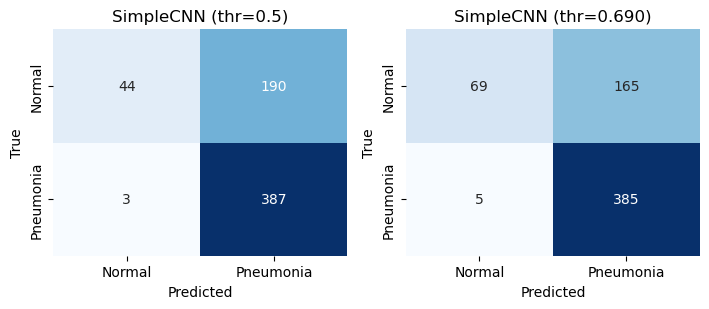

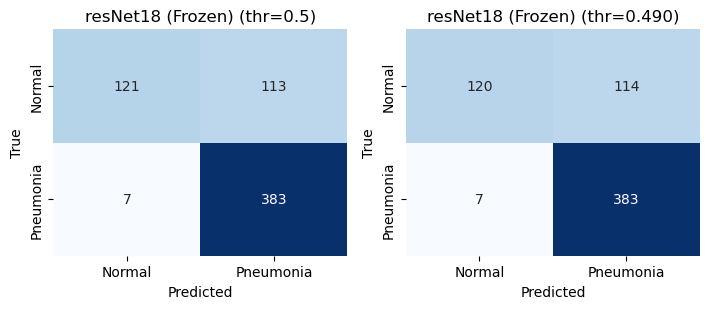

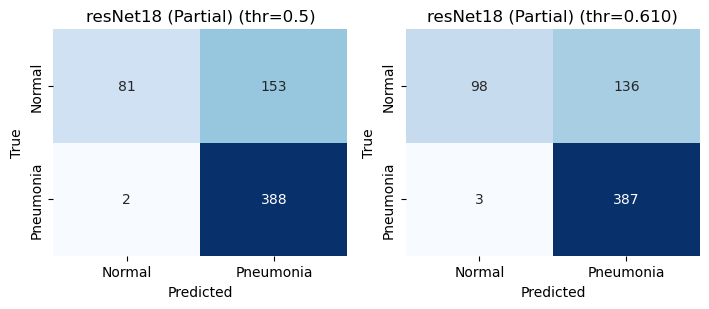

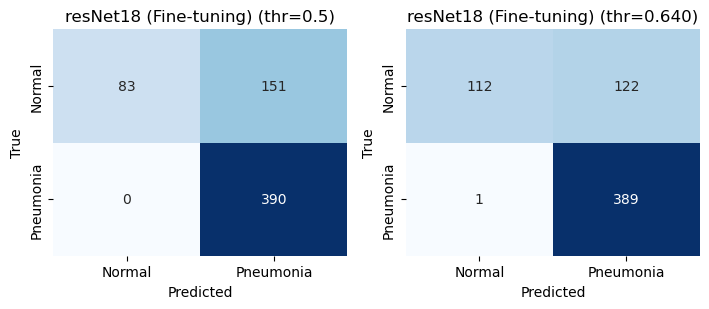

In [63]:
def plot_cm_pair(model_name):
    y_true0, y_pred0 = cm_test_base[model_name]
    y_true1, y_pred1 = cm_test_with_threshold[model_name]

    cm0 = confusion_matrix(y_true0, y_pred0)
    cm1 = confusion_matrix(y_true1, y_pred1)

    fig, axes = plt.subplots(1, 2, figsize=(7.2, 3.2))
    for ax, cm, title in zip(
        axes,
        [cm0, cm1],
        [f"{model_name} (thr=0.5)", f"{model_name} (thr={thresholds[model_name]:.3f})"]
    ):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Normal","Pneumonia"], yticklabels=["Normal","Pneumonia"],
                    cbar=False, ax=ax)
        ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.tight_layout(); plt.show()

for name in models_to_test_with_threshold.keys():
    plot_cm_pair(name)

# 5. 결과 요약

## 최종 F1 기준 순위(튜닝 임계값 적용)
| Rank | Model                    | F1 (tuned) |
|-----:|--------------------------|-----------:|
| 1    | resNet18 (Frozen)        | **0.8636** |
| 2    | resNet18 (Fine-tuning)   | 0.8635     |
| 3    | resNet18 (Partial)       | 0.8478     |
| 4    | SimpleCNN                | 0.8191     |

→ Frozen이 근소하게 1위, Fine-tuning이 사실상 동급 성능.

## 임계값 튜닝 효과 (Val에서 F1 최대화 → Test 적용)
- **전반적 경향:** 정밀도(Precision) ↑, 재현율(Recall) 약간 ↓
- **SimpleCNN:** Acc **+3.69%p**, Prec **+0.0293**, Rec **−0.0051**, F1 **+0.0187**
- **Partial:** Acc **+2.56%p**, Prec **+0.0228**, Rec **−0.0026**, F1 **+0.0142**
- **Fine-tuning:** Acc **+4.49%p**, Prec **+0.0404**, Rec **−0.0026**, F1 **+0.0257**
- **Frozen:** 거의 변화 없음 *(임계값 0.49로 미세 조정)*

## 오분류 패턴 (혼동행렬 기반 특이도 변화: TN/(TN+FP))
| Model                  | Before | After | Δ(pp) |
|------------------------|-------:|------:|------:|
| SimpleCNN              | 18.8%  | **29.5%** | **+10.7** |
| resNet18 (Partial)     | 34.6%  | **41.9%** | **+7.3**  |
| resNet18 (Fine-tuning) | 35.5%  | **47.9%** | **+12.4** |
| resNet18 (Frozen)      | 51.7%  | 51.3% | −0.4  |

→ 목표였던 **False Positive 감소(특이도 개선)** 가 SimpleCNN/Partial/Fine-tuning에서 뚜렷. Frozen은 기본 특이도가 높아 변화가 미미.

## 실험/분석 메모
- 높은 LR에서 **val loss 스파이크** 발생 → *warmup*, *ReduceLROnPlateau*, *OneCycleLR* 등 스케줄링 시도.
- **BatchNorm2d의 running stats는 `requires_grad=False`만으론 고정되지 않음** 확인  
  → 동결 블록에 **`.eval()` 강제 적용**(예: layer1~3 / 필요 시 layer4)으로 BN 통계 업데이트 차단 → 스파이크 완화.
- 기본 임계값 0.5에서는 **특이도↓(FP 많음)** 경향 → **모델별 최적 임계값** 적용으로 개선.